In [1]:
using Plots

In [2]:
using Distributions

In [44]:
function simulate_realization(M, s1, s2)
    # Number of days
    days = 60
    
    # State
    # number of worn machines
    W = zeros(Int, days)
    # number of broken machines
    B = zeros(Int, days)
    
    # probability of new -> worn
    p12 = (1/60) + (1/200 - 1/60) * sqrt(1 - ((10 - s1) / 10)^2)
    # probability of worn -> broken
    p23 = (1/30) + (1/100 - 1/30) * sqrt(1 - ((10 - s2) / 10)^2)
    
    # Simulate
    for i in 1:(days-1)
        B12 = rand(Binomial(M-W[i]-B[i], p12))
        B23 = rand(Binomial(W[i], p23))
        
        W[i+1] = W[i] + B12 - B23
        B[i+1] = B[i] +     + B23 - B[i]
    end
    
    N = M * ones(days) - W - B
    
    N, W, B
end

function simulate(M, s1, s2)
    gain = 0.0
    
    realizations = 10_000
    for _ in 1:realizations
        N, W, B = simulate_realization(M, s1, s2)
        gain += (M - B[end]) - 90 * B[end] - s1 - s2
    end
    
    return gain / realizations
end

# Total number of machines
M = 2_000

# Parameters
# money spent daily for maintainance of worn machines
s1 = 4
# money spent daily for maintainance of broken machines
s2 = 6
@time simulate(M, s1, s2)

  0.272519 seconds (172.00 k allocations: 39.055 MiB, 4.02% gc time)


1435.1184

In [240]:
X = []
y = []
@time for j=2:2:10, k=2:2:10
    gain = simulate(M, j, k)
    push!(X, [j, k])
    push!(y, [gain])
    println("($j, $k) = $(gain)")
end

(2, 2) = 1043.9034
(2, 4) = 1188.377
(2, 6) = 1293.8116
(2, 8) = 1355.6208
(2, 10) = 1374.9967
(4, 2) = 1227.3159
(4, 4) = 1348.6027
(4, 6) = 1433.262
(4, 8) = 1479.6922
(4, 10) = 1494.4271
(6, 2) = 1348.9394
(6, 4) = 1446.0111
(6, 6) = 1518.986
(6, 8) = 1559.8743
(6, 10) = 1570.3959
(8, 2) = 1419.2571
(8, 4) = 1507.5837
(8, 6) = 1562.7772
(8, 8) = 1602.1731
(8, 10) = 1616.3165
(10, 2) = 1436.5491
(10, 4) = 1523.4106
(10, 6) = 1579.7416
(10, 8) = 1618.8463
(10, 10) = 1628.2668
  5.697521 seconds (1.50 M allocations: 824.241 MiB, 2.96% gc time)


---

In [241]:
X

25-element Array{Any,1}:
 [2, 2]
 [2, 4]
 [2, 6]
 [2, 8]
 [2, 10]
 [4, 2]
 [4, 4]
 [4, 6]
 [4, 8]
 [4, 10]
 [6, 2]
 [6, 4]
 [6, 6]
 [6, 8]
 [6, 10]
 [8, 2]
 [8, 4]
 [8, 6]
 [8, 8]
 [8, 10]
 [10, 2]
 [10, 4]
 [10, 6]
 [10, 8]
 [10, 10]

In [242]:
y

25-element Array{Any,1}:
 [1043.9034]
 [1188.377]
 [1293.8116]
 [1355.6208]
 [1374.9967]
 [1227.3159]
 [1348.6027]
 [1433.262]
 [1479.6922]
 [1494.4271]
 [1348.9394]
 [1446.0111]
 [1518.986]
 [1559.8743]
 [1570.3959]
 [1419.2571]
 [1507.5837]
 [1562.7772]
 [1602.1731]
 [1616.3165]
 [1436.5491]
 [1523.4106]
 [1579.7416]
 [1618.8463]
 [1628.2668]

---

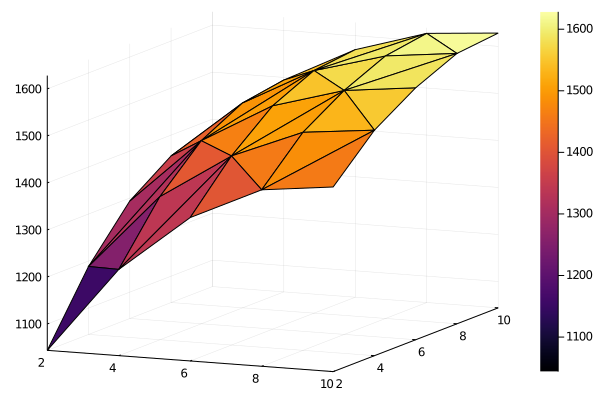

In [308]:
surface([x[1] for x in X], [x[2] for x in X], [y_[1] for y_ in y])

---

In [63]:
using Random

In [115]:
sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x) * (1 - sigma(x))

sigma_prime (generic function with 1 method)

In [170]:
using LinearAlgebra

In [331]:
function nn(x, W1, b1, W2, b2)
    z1 = W1 * x + b1
    a1 = sigma.(z1)
    z2 = W2 * a1 + b2
    a2 = z2
    return a2[1]
end

function compute_loss(W1, b1, W2, b2)
    loss = 0.0
    for (x, y_true) in zip(X, y)
        y_hat = nn(x, W1, b1, W2, b2)

        loss += (y_hat[1] - y_true[1])^2
    end
    loss /= (2 * size(X, 1))
    return loss
end

compute_loss (generic function with 1 method)

In [495]:
Random.seed!(1234);

mu = 1e-4

INPUT_SIZE = 2
HIDDEN_LAYER_SIZE = 100
W1 = randn(HIDDEN_LAYER_SIZE, INPUT_SIZE)
b1 = randn(HIDDEN_LAYER_SIZE, 1)

OUTPUT_LAYER_SIZE = 1
W2 = randn(OUTPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE)
b2 = randn(OUTPUT_LAYER_SIZE, 1)

for it in 1:1_000
    for (x, y_true) in zip(X, y)
        # Forward step to evaluate intermediate results
        z1 = W1 * x + b1
        a1 = sigma.(z1)
        z2 = W2 * a1 + b2
        a2 = z2

        # Backward step to evaluate parameter derivatives w.r.t. loss
        # d(loss)/d(z2) is `dz2`
        dz2 = a2 - y_true
        dW2 = dz2 * a1'
        db2 = dz2

        dz1 = (W2' * dz2) .* sigma_prime.(z1)
        dW1 = dz1 * x'
        db1 = dz1

        # Steepest descent to find optimal parameters
        W2 -= mu * dW2
        b2 -= mu * db2

        W1 -= mu * dW1
        b1 -= mu * db1
    end
    
    mu *= 0.9995
    
    if it % 200 == 0
        println("[$it]: $(round(compute_loss(W1, b1, W2, b2), digits=3))")
    end
end

[200]: 39.335
[400]: 5.182
[600]: 1.727
[800]: 1.189
[1000]: 0.987


---

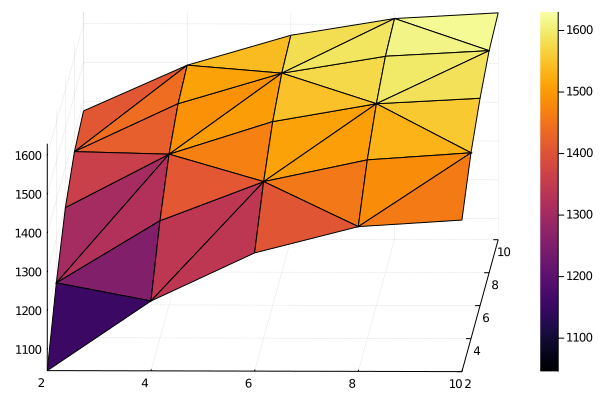

In [496]:
surface([x[1] for x in X], [x[2] for x in X], [nn(x, W1, b1, W2, b2) for (x,y) in zip(X,y)], camera=(5, 45))

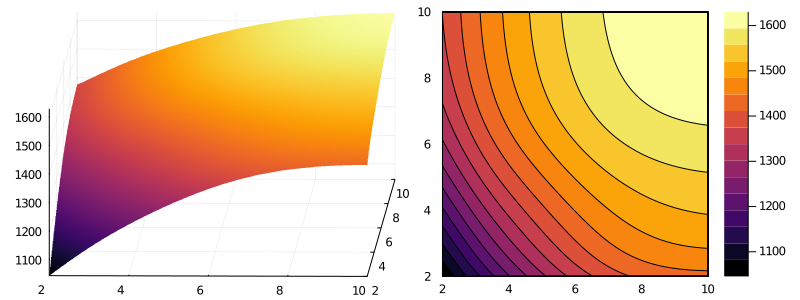

In [497]:
function plot_surface()
    plot(
        st=:surface,
        2:0.1:10,
        2:0.1:10,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
        camera=(5,45),
        legend=false
    )
end

function plot_contour()
    contourf(
        2:0.1:10,
        2:0.1:10,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2)
    )
end
plot(plot_surface(), plot_contour(), size=(800, 300))

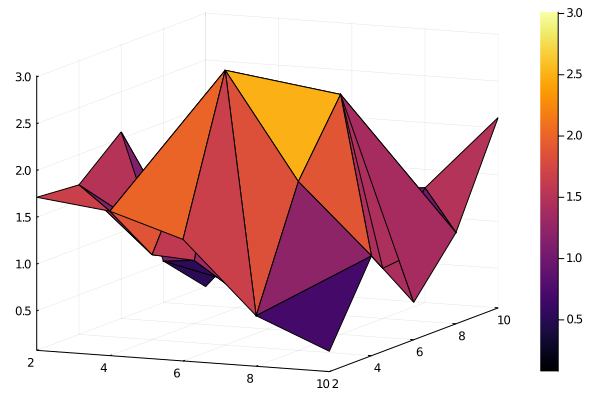

In [498]:
surface([x[1] for x in X], [x[2] for x in X], [abs(y[1]-nn(x, W1, b1, W2, b2)) for (x,y) in zip(X,y)])

In [499]:
for x in [[0.2, 0.5], [0.3, 0.9], [0.1, 0.9]]
    gain_nn = nn(x, W1, b1, W2, b2)
    gain_simulation = simulate(M, x[1], x[2])
    println("Gain NN: $(gain_nn), Gain Simulation: $(gain_simulation)")
end

Gain NN: 689.1293801071629, Gain Simulation: 485.09639999990816
Gain NN: 756.3213074685949, Gain Simulation: 589.4920999998918
Gain NN: 730.3128982287263, Gain Simulation: 505.3624


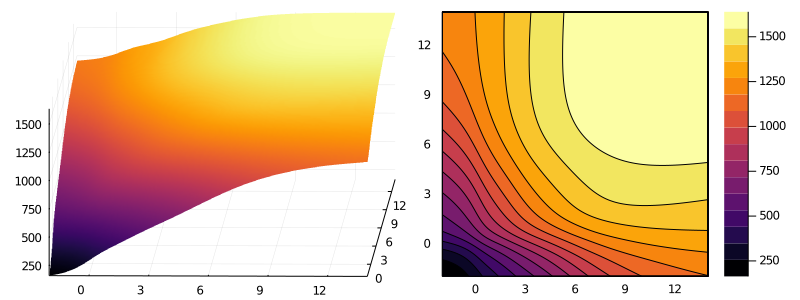

In [500]:
function plot_surface()
    plot(
        st=:surface,
        -2:0.1:14,
        -2:0.1:14,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
        camera=(5,45),
        legend=false
    )
end

function plot_contour()
    contourf(
        -2:0.1:14,
        -2:0.1:14,
        (x1, x2) -> nn([x1, x2], W1, b1, W2, b2)
    )
end
plot(plot_surface(), plot_contour(), size=(800, 300))

---

Ma perche' nel punto 1.2 devo usare uno stochastic gradient descent se il neural network e' una funzione deterministica??

In [502]:
max(y...)

1-element Array{Float64,1}:
 1628.2668

In [555]:
1.2^10

6.191736422399997

In [599]:
function maximize_gain()
    x = [2., 2.]
    
    mu = 1
    
    C = 0.1
    
    for m in 1:1000
        println("$(round.(x, digits=2)), $(round(nn(x, W1, b1, W2, b2), digits=0))")
        
        h = rand([1, -1], size(x, 1))
        c = C / m^0.2
        println("c=$(round(c, digits=3))")
        
        finite_diff = nn(x + c*h, W1, b1, W2, b2) - nn(x - c*h, W1, b1, W2, b2)
        dx = [finite_diff / 2*c*h[i] for i in 1:size(x, 1)]
        
        x += mu * dx
    end
end

maximize_gain()

[2.0, 2.0], 1046.0
c=0.1
[3.84, 3.84], 1329.0
c=0.087
[4.74, 4.74], 1422.0
c=0.08
[4.78, 4.69], 1423.0
c=0.076
[4.82, 4.65], 1423.0
c=0.072
[4.85, 4.62], 1423.0
c=0.07
[5.3, 5.06], 1461.0
c=0.068
[5.32, 5.04], 1461.0
c=0.066
[5.34, 5.02], 1461.0
c=0.064
[5.36, 5.0], 1461.0
c=0.063
[5.67, 5.32], 1485.0
c=0.062
[5.69, 5.31], 1485.0
c=0.061
[5.7, 5.3], 1485.0
c=0.06
[5.71, 5.29], 1486.0
c=0.059
[5.72, 5.28], 1486.0
c=0.058
[5.73, 5.27], 1486.0
c=0.057
[5.97, 5.51], 1502.0
c=0.057
[6.18, 5.73], 1516.0
c=0.056
[6.19, 5.72], 1516.0
c=0.055
[6.38, 5.91], 1528.0
c=0.055
[6.38, 5.91], 1528.0
c=0.054
[6.38, 5.91], 1528.0
c=0.054
[6.39, 5.91], 1528.0
c=0.053
[6.39, 5.91], 1528.0
c=0.053
[6.39, 5.91], 1528.0
c=0.053
[6.39, 5.9], 1528.0
c=0.052
[6.39, 5.9], 1528.0
c=0.052
[6.39, 5.9], 1528.0
c=0.051
[6.39, 5.9], 1528.0
c=0.051
[6.55, 6.05], 1537.0
c=0.051
[6.69, 6.2], 1545.0
c=0.05
[6.69, 6.2], 1545.0
c=0.05
[6.82, 6.33], 1551.0
c=0.05
[6.94, 6.45], 1557.0
c=0.049
[7.06, 6.57], 1563.0
c=0.049
[7.06

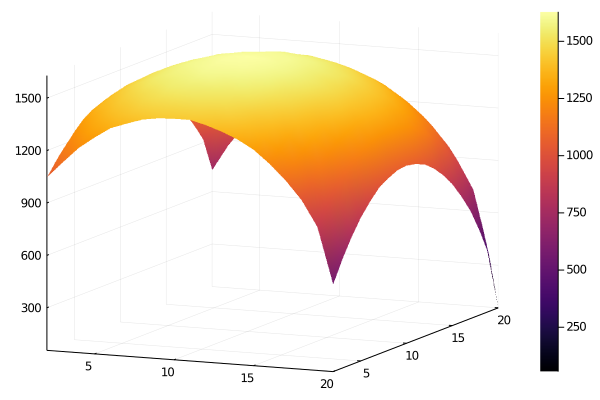

In [587]:
surface(
    2:1:20,
    2:1:20,
    (x1, x2) -> simulate(M, x1, x2),
)

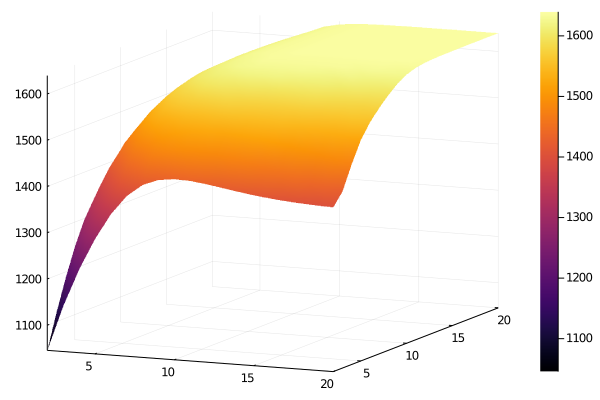

In [600]:
surface(
    2:1:20,
    2:1:20,
    (x1, x2) -> nn([x1, x2], W1, b1, W2, b2),
)